<a href="https://colab.research.google.com/github/Mohamed-Khalil67/Deep-Learning/blob/main/Atelier_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project Deep learning


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.3 MB/s 
     |████████████████████████████████| 189 kB 57.0 MB/s 
     |████████████████████████████████| 1.2 MB 48.5 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 298 kB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

##Environnement matériel et logiciel



In [4]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11856109433959176621
xla_global_id: -1
]


In [6]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Prise en charge des données 
### Structure des données 
```
data_dir
└───subsample/
│   └───train/
│   │   └───cats/
│   │   │   │   cat.0.jpg
│   │   │   │   cat.1.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.0.jpg
│   │   │   │   dog.1.jpg
│   │   │   │   ...
│   └───test/
│   │   └───cats/
│   │   │   │   cat.1000.jpg
│   │   │   │   cat.1000.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.1000.jpg
│   │   │   │   dog.1000.jpg
│   │   │   │   ...
```

##Création d'un jeu d'apprentissage et de validation

In [7]:
data_dir = 'gdrive/MyDrive/kaggle/' # chemin d'accès aux données

N_train = 200 #2000
N_val = 80 #800

data_dir_sub = data_dir+'subsample_%d_Ntrain_%d_Nval' %(N_train, N_val)

##Illustration des données

PIL image : The module also provides a number of factory functions, including functions to load images from files, and to create new images. Examples : Open, rotate, and display an image (using the default viewer)


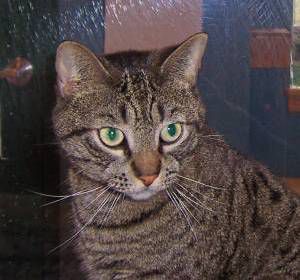

In [8]:
img = kpi.load_img(data_dir_sub+'/train/cats/cat.1.jpg')  # this is a PIL image
img

La fonction `img_to_array` génére un `array numpy` a partir d'une image PIL .

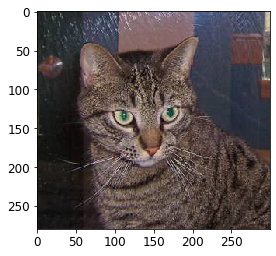

In [9]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

##Pré-traitements

on veut voire les shapes différents.

In [10]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((374, 500, 3), (280, 300, 3))

On utilise term réseau pour les couches de neurones afin de décriver les processings fait sur les inputs.

La fonction `ImageDataGenerator` de `Keras` permet de remèdier à ce problème.

Plus généralement cette fonction applique un certain nombre de traitements (transformation, normalisation) aléatoires sur les images de sorte que le modèle n'apprenne jamais deux fois la même image.

Quelques arguments de cette fonction:
* `rotation_range`: Un interval représentant les degrés possibles de rotation de l'image,
* `width_shift` and `height_shift`: intervales au sein desquels les données peuvent être translatées horizontalement ou verticalement, 
* `rescale`:  Une valeur par lequelle les données sont multipliées,
* `shear_range`:  Transvection,
* `zoom_range`: Permet des zoom au sein d'une image,
* `horizontal_flip`: Inverse aléatoirement des images selon l'axe horizontal,
* `fill_mode`: La strategie adoptée pour combler les pixels manquants après une transformation.

In [11]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

La commande `.flow()` genere de nouveaux exemples à partir de l'image originale et les sauve dans le dossier spécifié dans `save_to_dir`.

On force l'arrêt de cette génération après huits images générées.

In [12]:
img_width = 150
img_height = 150

img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  